In [4]:
#!pip install obspy
#!pip install pyts

In [17]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
%matplotlib inline

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

# df_train = pd.read_csv("/kaggle/input/liverpool-ion-switching/train.csv")
# df_test = pd.read_csv("/kaggle/input/liverpool-ion-switching/test.csv")
df_train = pd.read_csv("train_clean.csv")
df_new = pd.read_csv("test_clean.csv")

In [19]:
# GENERATE FEATURES - taking batch into account
# TODO centered rolling feats, forward rolling feats

BATCH_SIZE = 500000
for i in range(10):
    df_train.loc[i * BATCH_SIZE:((i + 1) * BATCH_SIZE) - 1, 'batch'] = i

# TODO: fix batches for test (niso na 500k ampak na 100k za prva 2 batcha)
#for i in range(4):
#    df_test.loc[i * BATCH_SIZE:((i + 1) * BATCH_SIZE) - 1, 'batch'] = i

df_train['batch'] = df_train['batch'].astype(np.uint8)
#df_test['batch'] = df_test['batch'].astype(np.uint8)

# Rolling features
#window_sizes = [10, 50, 500, 1000, 5000]
window_sizes = [11, 25, 51, 101, 1001] # for centered

def gen_features(df, window_sizes, use_batches=False):
    for window in window_sizes:
        if use_batches:
            df[f'rolling_mean_{window}'] = df.groupby('batch')['signal'].rolling(
                window=window, min_periods=1, center=True).mean().reset_index()['signal']
            df[f'rolling_std_{window}'] = df.groupby('batch')['signal'].rolling(
                window=window, min_periods=1, center=True).std().reset_index()['signal']
            df[f'rolling_var_{window}'] = df.groupby('batch')['signal'].rolling(
                window=window, min_periods=1, center=True).var().reset_index()['signal']
            df[f'rolling_min_{window}'] = df.groupby('batch')['signal'].rolling(
                window=window, min_periods=1, center=True).min().reset_index()['signal']
            df[f'rolling_max_{window}'] = df.groupby('batch')['signal'].rolling(
                window=window, min_periods=1, center=True).max().reset_index()['signal']

            df[f'rolling_min_max_ratio_{window}'] = df[f'rolling_min_{window}'] / df[f'rolling_max_{window}']
            df[f'rolling_max_min_diff_{window}'] = df[f'rolling_max_{window}'] - df[f'rolling_min_{window}']

            norm = (df['signal'] - df[f'rolling_min_{window}']) / df[f'rolling_max_min_diff_{window}']
            df[f'norm_{window}'] = norm # * (np.floor(df_train[f'rolling_max_{window}']) - np.ceil(df_train[f'rolling_min_{window}']))
        else:
            df[f'rolling_mean_{window}'] = df['signal'].rolling(
                window=window, min_periods=1, center=True).mean()
            df[f'rolling_std_{window}'] = df['signal'].rolling(
                window=window, min_periods=1, center=True).std()
            df[f'rolling_var_{window}'] = df['signal'].rolling(
                window=window, min_periods=1, center=True).var()
            df[f'rolling_min_{window}'] = df['signal'].rolling(
                window=window, min_periods=1, center=True).min()
            df[f'rolling_max_{window}'] = df['signal'].rolling(
                window=window, min_periods=1, center=True).max()

            df[f'rolling_min_max_ratio_{window}'] = df[f'rolling_min_{window}'] / df[f'rolling_max_{window}']
            df[f'rolling_max_min_diff_{window}'] = df[f'rolling_max_{window}'] - df[f'rolling_min_{window}']

            norm = (df['signal'] - df[f'rolling_min_{window}']) / df[f'rolling_max_min_diff_{window}']
            df[f'norm_{window}'] = norm
            
    # Special features
    df['signal_abs'] = abs(df['signal'])
    df['signal_sq'] = np.sign(df['signal']) * df['signal'] ** 2
    df['signal_sqroot'] = np.sign(df['signal']) * abs(df['signal']) ** 0.5

    df = df.replace([np.inf, -np.inf], np.nan)
    df.fillna(0, inplace=True)
    
    return df

df_train = gen_features(df_train, window_sizes, use_batches=True)
df_train.head()

df_new = gen_features(df_new, window_sizes)

#plt.figure(figsize=(25, 10))
#plt.plot(df_train.time, df_train.signal) #[500000*6-100:500000*6+100]
#plt.plot(df_train.time, df_train.norm_10)
#plt.plot(df_train.time, df_train.open_channels+10)
#plt.plot(df_test.time, df_test.signal)

In [ ]:
# DEPRECATED
# GENERATE SEQUENCES

#SEQ_LEN_BEFORE = (5 - 1) // 2 + 1
#SEQ_LEN_AFTER = (5 - 1) // 2
SEQ_LEN_BEFORE = 50
SEQ_LEN_AFTER = 50
SEQ_LEN = SEQ_LEN_BEFORE + 1 + SEQ_LEN_AFTER

# TODO maybe: ne vsakič fillna (za train dropam, za test fillna)
def to_supervised(df, n_before=1, n_after=1):
    col = 'detrended'
    cols, names = list(), list()
    # (t-n, ... t-1)
    for i in range(n_before, 0, -1):
        cols.append(df.groupby('batch')[col].shift(i).fillna(method='bfill'))
        names.append(f'shift_t-{i}')
    
    # (t)
    cols.append(df[col])
    names.append(f'shift_t')
    
    # (t+1, ... t+n)
    for i in range(1, n_after+1):
        #cols.append(df.shift(-i).fillna(method='ffill'))
        cols.append(df.groupby('batch')[col].shift(-i).fillna(method='ffill'))
        names.append(f'shift_t+{i}')

    agg = pd.concat(cols, axis=1)
    agg.columns = names
    return agg

df_train_X = to_supervised(df_train, SEQ_LEN_BEFORE, SEQ_LEN_AFTER)
#df_train_X.iloc[499_999:500010]

In [4]:
print(df_train_X.to_numpy().shape)

(5000000, 101)


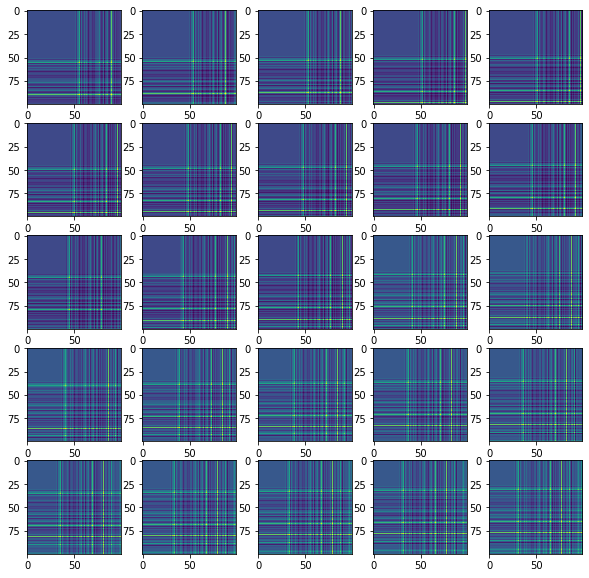

In [5]:
from pyts.image import GramianAngularField

gasf = GramianAngularField(image_size=100, sample_range=(0, 1), method='summation')
X_gasf = gasf.fit_transform(df_train_X.to_numpy()[4500000:5000000])

#print((df_train['open_channels'][7225:7250]))
fig = plt.figure(figsize=(10, 10))
for i in range(5):
    for j in range(5):
        plt.subplot(5, 5, i*5+j+1)
        plt.imshow(X_gasf[i*5+j])

In [6]:
print(X_gasf.shape)

(500000, 100, 100)


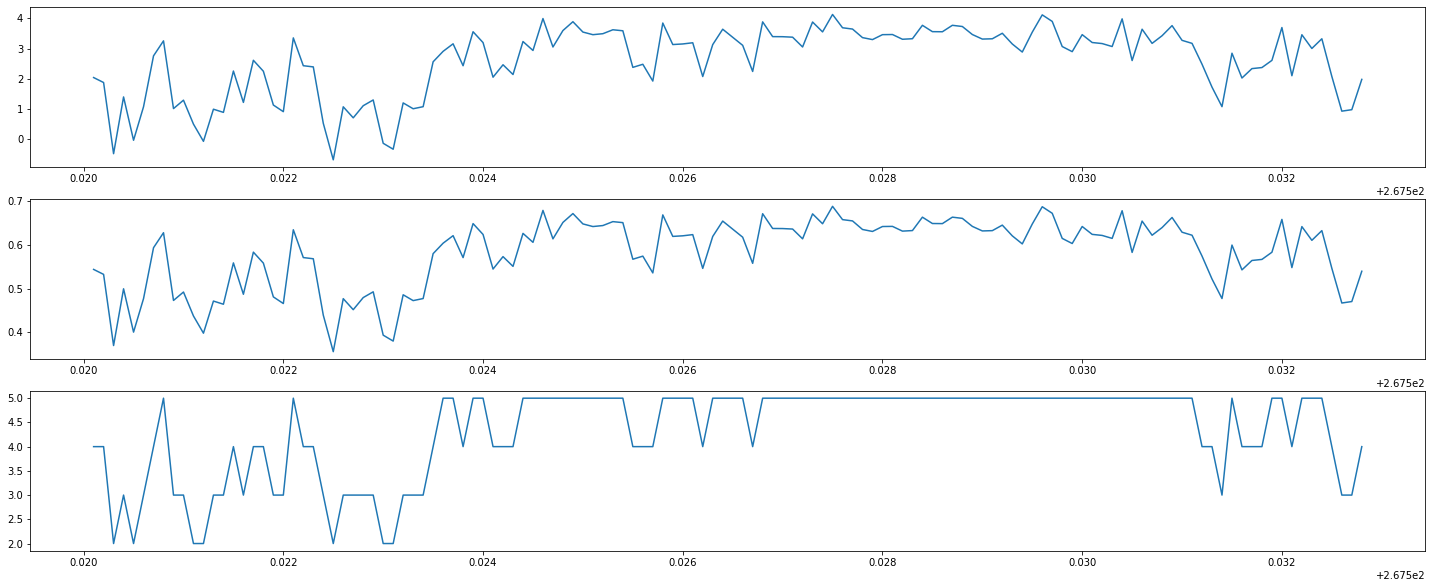

In [21]:
from sklearn.preprocessing import MinMaxScaler

seg = 20900

plt.figure(figsize=(25, 10))
plt.subplot(3, 1, 1)
#plt.plot(df_train.time[seg*500000:(seg+1)*500000], df_train.signal[seg*500000:(seg+1)*500000])
plt.plot(df_train.time[seg*128:(seg+1)*128], df_train.signal[seg*128:(seg+1)*128])

plt.subplot(3, 1, 2)
#plt.plot(df_train.time[seg*128:(seg+1)*128], df_train.detrended[seg*128:(seg+1)*128])
x_scaler = MinMaxScaler(feature_range=(0, 1))
X_train = x_scaler.fit_transform(np.expand_dims(df_train.signal.to_numpy(), 1))
plt.plot(df_train.time[seg*128:(seg+1)*128], X_train[seg*128:(seg+1)*128])

plt.subplot(3, 1, 3)
#plt.plot(df_train.time[seg*500000:(seg+1)*500000], df_train.open_channels[seg*500000:(seg+1)*500000])
plt.plot(df_train.time[seg*128:(seg+1)*128], df_train.open_channels[seg*128:(seg+1)*128])

0     1240152
1      985865
3      668609
2      553924
4      403410
5      277877
7      265015
8      245183
6      188112
9      136120
10      35733
Name: open_channels, dtype: int64


<BarContainer object of 11 artists>

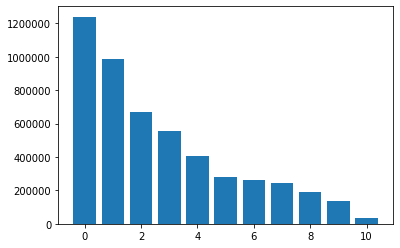

In [4]:
nuniq = df_train.open_channels.value_counts()
print(nuniq)
plt.bar(range(len(nuniq)), list(nuniq))

In [7]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

Using TensorFlow backend.
C:\Users\User\Anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\User\Anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\User\Anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\User\Anaconda3\envs\tf-gpu\lib\site-pa

['/job:localhost/replica:0/task:0/device:GPU:0']

In [8]:
from tensorflow.keras.models import Sequential, Model
from keras.regularizers import l2
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam

# taken ResNet block but changed it to 1D
def get_model_res(input_shape, optimizer):
    
    def res_block(X, n_filters, conv_skip=False):
        X_skip = X
        if conv_skip:
            X_skip = Conv1D(filters=n_filters[2], kernel_size=1, strides=1, padding='same')(X_skip)
            X_skip = BatchNormalization()(X_skip)
            X_skip = Activation('relu')(X_skip)
        
        X = Conv1D(filters=n_filters[0], kernel_size=1, strides=1, padding='same')(X)
        X = BatchNormalization()(X)
        X = Activation('relu')(X)
        
        X = Conv1D(filters=n_filters[1], kernel_size=3, strides=1, padding='same')(X)
        X = BatchNormalization()(X)
        X = Activation('relu')(X)
        
        X = Conv1D(filters=n_filters[2], kernel_size=1, strides=1, padding='same')(X)
        X = BatchNormalization()(X)
        X = Activation('relu')(X)
        
        X = Add()([X, X_skip])
        X = Activation('relu')(X)
        
        return X
        
    X_input = Input(shape=input_shape)
    X = Conv1D(filters=256, kernel_size=3, padding='same')(X_input)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)
    X = MaxPool1D(pool_size=2)(X)
    
    X = res_block(X, [128, 128, 256])
    X = res_block(X, [128, 128, 256])
    X = res_block(X, [128, 128, 256])
    X = res_block(X, [64, 64, 128], conv_skip=True)
    X = MaxPool1D(pool_size=2)(X)
    
    X = res_block(X, [64, 64, 128])
    X = res_block(X, [64, 64, 128])
    X = res_block(X, [64, 64, 128])
    X = res_block(X, [32, 32, 64], conv_skip=True)
    X = MaxPool1D(pool_size=2)(X)
    
    X = Bidirectional(GRU(128))(X)
    
    #X = Flatten()(X)
    #X = Dense(128, activation='relu')(X)
    X = Dropout(0.2)(X)
    X = Dense(11, activation='softmax')(X)

    model = Model(inputs=X_input, outputs=X, name='ResLSTM')
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    model.summary()
    return model

# basic CNN
def get_model_images(input_shape, optimizer):

    X_input = Input(shape=input_shape)
    
    X = Conv2D(filters=128, kernel_size=3, padding='same')(X_input)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)
    X = MaxPool2D(pool_size=2)(X)
    
    X = Conv2D(filters=256, kernel_size=3, padding='same')(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)
    X = MaxPool2D(pool_size=2)(X)
    
    X = Conv2D(filters=128, kernel_size=3, padding='same')(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)
    X = MaxPool2D(pool_size=2)(X)

    X = Flatten()(X)
    X = Dense(512)(X)
    X = Dense(11, activation='softmax')(X)

    model = Model(inputs=X_input, outputs=X, name='conv2d')
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    model.summary()
    return model

# taken from paper: https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=8141873
def get_model(input_shape, optimizer):
    
    def conv1d(layer_input, filters, k_size=3, strides=1, bn=True):
        d = Conv1D(filters, kernel_size=k_size, strides=strides, padding='same')(layer_input)
        if bn:
            d = BatchNormalization(momentum=0.99, epsilon=0.001)(d)
        d = Activation('relu')(d)
        #d = LeakyReLU(alpha=0.2)(d)
        return d
    
    x_input = Input(shape=input_shape)
    x_in_lstm = Permute((2, 1))(x_input)
    
    X = conv1d(x_input, 128, 1)
    X = conv1d(X, 256, 8, 2)
    X = conv1d(X, 512, 5, 2)
    X = conv1d(X, 512, 3, 2)
    X = GlobalAveragePooling1D()(X)
    
    x = Bidirectional(LSTM(256, return_sequences=True))(x_in_lstm)
    x = Bidirectional(LSTM(256))(x)
    x = Dropout(0.8)(x)
    
    x = Concatenate()([x, X])
    x = Dense(128)(x)
    output = Dense(11, activation='softmax')(x)

    model = Model(inputs=x_input, outputs=output)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    model.summary()
    return model


# https://github.com/ronakvijay/Protein_Sequence_Classification/blob/master/Pfam_protein_sequence_classification.ipynb
# taken from above link, ProtCNN model
def get_model_ProtCNN(input_shape, optimizer):
    
    def residual_block(data, filters, d_rate):
        shortcut = data

        bn1 = BatchNormalization()(data)
        act1 = Activation('relu')(bn1)
        conv1 = Conv1D(filters, 1, dilation_rate=d_rate, padding='same', kernel_regularizer=l2(0.001))(act1)

        #bottleneck convolution
        bn2 = BatchNormalization()(conv1)
        act2 = Activation('relu')(bn2)
        conv2 = Conv1D(filters, 3, padding='same', kernel_regularizer=l2(0.001))(act2)

        #skip connection
        x = Add()([conv2, shortcut])

        return x
        
    x_input = Input(shape=input_shape)

    #initial conv
    conv = Conv1D(128, 1, padding='same')(x_input) 

    # per-residue representation
    res1 = residual_block(conv, 128, 2)
    res2 = residual_block(res1, 128, 3)

    x = MaxPooling1D(3)(res2)
    x = Dropout(0.5)(x)
    
    #x = Bidirectional(GRU(128))(x) # my added

    # softmax classifier
    x = Flatten()(x)
    x_output = Dense(11, activation='softmax', kernel_regularizer=l2(0.0001))(x)

    model = Model(inputs=x_input, outputs=x_output)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    model.summary()
    return model

# resnet blocks but for seq to seq translation
def get_model_custom(input_shape, optimizer):
    
    def res_block(X, n_filters, conv_skip=False):
        X_skip = X
        if conv_skip:
            X_skip = Conv1D(filters=n_filters[2], kernel_size=1, strides=1, padding='same')(X_skip)
            X_skip = BatchNormalization()(X_skip)
            X_skip = Activation('relu')(X_skip)
        
        X = Conv1D(filters=n_filters[0], kernel_size=1, strides=1, padding='same')(X)
        X = BatchNormalization()(X)
        X = Activation('relu')(X)
        
        X = Conv1D(filters=n_filters[1], kernel_size=3, strides=1, padding='same')(X)
        X = BatchNormalization()(X)
        X = Activation('relu')(X)
        
        X = Conv1D(filters=n_filters[2], kernel_size=1, strides=1, padding='same')(X)
        X = BatchNormalization()(X)
        X = Activation('relu')(X)
        
        X = Add()([X, X_skip])
        X = Activation('relu')(X)
        
        return X
        
    X_input = Input(shape=input_shape)
    X = Conv1D(filters=256, kernel_size=3, padding='same')(X_input)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)
    
    X = res_block(X, [128, 128, 256])
    X = res_block(X, [128, 128, 256])
    X = res_block(X, [128, 128, 256])
    X = res_block(X, [64, 64, 128], conv_skip=True)
    
    X = Bidirectional(GRU(64, return_sequences=True))(X)
    
    X = Conv1D(filters=1, kernel_size=1, padding='same')(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)
    
    X = Add()([X, X_input])
    
    X = Flatten()(X)
    #X = Dropout(0.2)(X)
    X = Dense(input_shape[0], activation='relu')(X)

    model = Model(inputs=X_input, outputs=X, name='sig2sig')
    model.compile(loss='mse', optimizer=optimizer, metrics=['mae'])
    model.summary()
    return model

# generator from: https://github.com/eriklindernoren/Keras-GAN/blob/master/pix2pix/pix2pix.py
def get_model_unet(input_shape, optimizer):

    def conv2d(layer_input, filters, f_size=3, bn=True):
        """Layers used during downsampling"""
        d = Conv1D(filters, kernel_size=f_size, strides=2, padding='same')(layer_input)
        d = LeakyReLU(alpha=0.2)(d)
        if bn:
            d = BatchNormalization(momentum=0.8)(d)
        return d

    def deconv2d(layer_input, skip_input, filters, f_size=3, dropout_rate=0):
        """Layers used during upsampling"""
        u = UpSampling1D(size=2)(layer_input)
        u = Conv1D(filters, kernel_size=f_size, strides=1, padding='same', activation='relu')(u)
        if dropout_rate:
            u = Dropout(dropout_rate)(u)
        u = BatchNormalization(momentum=0.8)(u)
        u = Add()([u, skip_input])
        return u
    
    n_filters = 64

    # Image input
    d0 = Input(shape=input_shape)

    # Downsampling
    d1 = conv2d(d0, n_filters, bn=False)
    d2 = conv2d(d1, n_filters*2)
    d3 = conv2d(d2, n_filters*4)
    d4 = conv2d(d3, n_filters*8)
    d5 = conv2d(d4, n_filters*8)
    d6 = conv2d(d5, n_filters*8)
    d7 = conv2d(d6, n_filters*8)

    # Upsampling
    u1 = deconv2d(d7, d6, n_filters*8)
    u2 = deconv2d(u1, d5, n_filters*8)
    u3 = deconv2d(u2, d4, n_filters*8)
    u4 = deconv2d(u3, d3, n_filters*4)
    u5 = deconv2d(u4, d2, n_filters*2)
    u6 = deconv2d(u5, d1, n_filters)

    u7 = UpSampling1D(size=2)(u6)
    
    #u7 = Bidirectional(GRU(64, return_sequences=True))(u7)
    
    output_img = Conv1D(1, kernel_size=3, strides=1, padding='same', activation='sigmoid')(u7)
    output_img = Flatten()(output_img)

    model = Model(inputs=d0, outputs=output_img, name='sig2sig')
    model.compile(loss='mse', optimizer=optimizer, metrics=['mae'])
    model.summary()
    return model
    

In [9]:
from tensorflow.keras.callbacks import Callback

class MacroF1(Callback):
    def __init__(self, model, inputs, targets):
        self.model = model
        self.inputs = inputs
        self.targets = np.argmax(targets, axis=-1)
        
    def on_epoch_end(self, epoch, logs={}):
        preds = np.argmax(self.model.predict(self.inputs), axis=-1)
        score = f1_score(self.targets, preds, average='macro')
        print(f' - val_macro_F1: {score:.5f}')

In [10]:
#TODO maybe: change the code so that sequences are created here instead of above
# creates a batch of bootstrapped examples
# doesn't take data batches into account & have to pad test data
def batch_generator(batch_size, X, y, n_before, n_after):
    while True:
        # Allocate a new array for the batch of input-signals.
        seq_len = n_before + 1 + n_after
        x_shape = (batch_size, seq_len, X.shape[1])
        x_batch = np.zeros(shape=x_shape, dtype=np.float16)

        # Allocate a new array for the batch of output-signals.
        y_shape = (batch_size, y.shape[1])
        y_batch = np.zeros(shape=y_shape, dtype=np.float16)

        # Fill the batch with random sequences of data.
        for i in range(batch_size):
            # Get a random start-index.
            # This points somewhere into the training-data.
            idx = np.random.randint(n_before, X.shape[0] - n_after)
            
            # Copy the sequences of data starting at this index.
            x_batch[i] = X[idx-n_before:idx+n_after+1]
            y_batch[i] = y[idx]
        
        #print(x_batch.shape)
        yield (x_batch, y_batch)


# generates input and output sequences for signal-to-signal translation
def seq2seq_generator(batch_size, X, y, seq_len):
    while True:
        # Allocate a new array for the batch of input-signals.
        x_shape = (batch_size, seq_len, 1)
        x_batch = np.zeros(shape=x_shape, dtype=np.float16)

        # Allocate a new array for the batch of output-signals.
        y_shape = (batch_size, seq_len)
        y_batch = np.zeros(shape=y_shape, dtype=np.float16)

        # Fill the batch with random sequences of data.
        for i in range(batch_size):
            # Get a random start-index.
            # This points somewhere into the training-data.
            idx = np.random.randint(X.shape[0] - seq_len)
            
            # Copy the sequences of data starting at this index.
            x_batch[i] = X[idx:idx+seq_len]
            y_batch[i] = y[idx:idx+seq_len]
        
        #print(x_batch.shape)
        yield (x_batch, y_batch)

#X = np.array([[1, 11], [2, 22], [3, 33], [4, 44], [5, 55]])
#y = np.array([[0, 1], [1, 0], [0, 1], [1, 0], [0, 1]])
#gen = batch_generator(2, X, y, 1, 2)
#print(next(gen))

#X = np.array([[1], [2], [3], [4], [5], [6]])
#y = np.array([1, 2, 3, 4, 5, 6])
#gen = seq_generator(2, X, y, 3)
#print(next(gen))

full shape: X  (5000000, 43) , y  (5000000,)
Training 1. Fold
X_train shape:  (4500000, 43)
y_train shape:  (4500000, 11)
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 3, 43)        0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 3, 128)       5632        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1 (BatchNo (None, 3, 128)       512         conv1d[0][0]                    

Epoch 10/200
781/781 [==============================] - 231s 296ms/step - loss: 0.1026 - acc: 0.9602 - val_loss: 0.0923 - val_acc: 0.9649
Epoch 11/200
781/781 [==============================] - 234s 299ms/step - loss: 0.1000 - acc: 0.9608 - val_loss: 0.0922 - val_acc: 0.9645
Epoch 12/200
166666/166666 [==============================] - 84s 507us/sample - loss: 0.0926 - acc: 0.9643

Epoch 00012: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.
781/781 [==============================] - 224s 287ms/step - loss: 0.0984 - acc: 0.9620 - val_loss: 0.0926 - val_acc: 0.9643
Epoch 13/200
781/781 [==============================] - 224s 287ms/step - loss: 0.0990 - acc: 0.9621 - val_loss: 0.0913 - val_acc: 0.9650
Epoch 14/200
166666/166666 [==============================] - 85s 507us/sample - loss: 0.0940 - acc: 0.9633

Epoch 00014: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.
781/781 [==============================] - 224s 286ms/step - loss: 0.0996 - acc: 0

781/781 [==============================] - 224s 286ms/step - loss: 0.0959 - acc: 0.9624 - val_loss: 0.0889 - val_acc: 0.9657
Epoch 45/200
781/781 [==============================] - 224s 286ms/step - loss: 0.0954 - acc: 0.9627 - val_loss: 0.0889 - val_acc: 0.9660
Epoch 46/200
781/781 [==============================] - 224s 286ms/step - loss: 0.0988 - acc: 0.9618 - val_loss: 0.0889 - val_acc: 0.9660
Epoch 47/200
781/781 [==============================] - 223s 286ms/step - loss: 0.0946 - acc: 0.9628 - val_loss: 0.0890 - val_acc: 0.9657
Epoch 48/200
781/781 [==============================] - 224s 286ms/step - loss: 0.0962 - acc: 0.9625 - val_loss: 0.0888 - val_acc: 0.9658
Epoch 49/200
781/781 [==============================] - 223s 286ms/step - loss: 0.0922 - acc: 0.9643 - val_loss: 0.0895 - val_acc: 0.9652
Epoch 50/200
781/781 [==============================] - 224s 286ms/step - loss: 0.0925 - acc: 0.9641 - val_loss: 0.0888 - val_acc: 0.9658
Epoch 51/200
781/781 [=========================

781/781 [==============================] - 223s 285ms/step - loss: 0.0921 - acc: 0.9646 - val_loss: 0.0885 - val_acc: 0.9659
Epoch 80/200
781/781 [==============================] - 223s 286ms/step - loss: 0.0926 - acc: 0.9641 - val_loss: 0.0882 - val_acc: 0.9659
Epoch 81/200
781/781 [==============================] - 223s 286ms/step - loss: 0.0937 - acc: 0.9635 - val_loss: 0.0885 - val_acc: 0.9660
Epoch 00081: early stopping
val_macro_f1: 0.9343876802087338


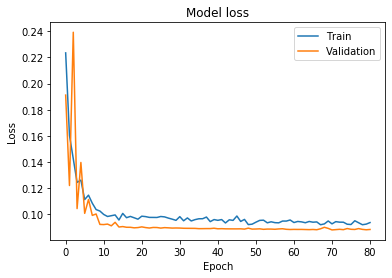

Training 2. Fold
X_train shape:  (4500000, 43)
y_train shape:  (4500000, 11)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 3, 43)        0                                            
__________________________________________________________________________________________________
conv1d_4 (Conv1D)               (None, 3, 128)       5632        input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1_4 (Batch (None, 3, 128)       512         conv1d_4[0][0]                   
__________________________________________________________________________________________________
activation_4 (Activation)       (None, 3, 128)       0           batch_normalization_v1_4[0][0]   
________________________________

166666/166666 [==============================] - 85s 508us/sample - loss: 0.0930 - acc: 0.9638

Epoch 00014: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.
781/781 [==============================] - 224s 286ms/step - loss: 0.0981 - acc: 0.9624 - val_loss: 0.0930 - val_acc: 0.9638
Epoch 15/200
781/781 [==============================] - 223s 286ms/step - loss: 0.0983 - acc: 0.9624 - val_loss: 0.0914 - val_acc: 0.9646
Epoch 16/200
781/781 [==============================] - 224s 286ms/step - loss: 0.0969 - acc: 0.9627 - val_loss: 0.0906 - val_acc: 0.9646
Epoch 17/200
166666/166666 [==============================] - 85s 509us/sample - loss: 0.0906 - acc: 0.9650

Epoch 00017: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.
781/781 [==============================] - 224s 287ms/step - loss: 0.0979 - acc: 0.9616 - val_loss: 0.0906 - val_acc: 0.9650
Epoch 18/200
166666/166666 [==============================] - 85s 507us/sample - loss: 0.0910 - acc: 0.9646


781/781 [==============================] - 224s 286ms/step - loss: 0.0927 - acc: 0.9642 - val_loss: 0.0889 - val_acc: 0.9653
Epoch 49/200
781/781 [==============================] - 227s 290ms/step - loss: 0.0929 - acc: 0.9636 - val_loss: 0.0887 - val_acc: 0.9654
Epoch 50/200
781/781 [==============================] - 230s 294ms/step - loss: 0.0924 - acc: 0.9644 - val_loss: 0.0890 - val_acc: 0.9656
Epoch 51/200
781/781 [==============================] - 231s 296ms/step - loss: 0.0941 - acc: 0.9632 - val_loss: 0.0894 - val_acc: 0.9654
Epoch 52/200
781/781 [==============================] - 229s 293ms/step - loss: 0.0926 - acc: 0.9638 - val_loss: 0.0889 - val_acc: 0.9656
Epoch 53/200
781/781 [==============================] - 228s 292ms/step - loss: 0.0921 - acc: 0.9645 - val_loss: 0.0889 - val_acc: 0.9654
Epoch 54/200
781/781 [==============================] - 256s 328ms/step - loss: 0.0954 - acc: 0.9625 - val_loss: 0.0888 - val_acc: 0.9656
Epoch 55/200
781/781 [=========================

781/781 [==============================] - 247s 316ms/step - loss: 0.0937 - acc: 0.9635 - val_loss: 0.0881 - val_acc: 0.9658
Epoch 84/200
781/781 [==============================] - 260s 333ms/step - loss: 0.0923 - acc: 0.9637 - val_loss: 0.0885 - val_acc: 0.9658
Epoch 85/200
781/781 [==============================] - 258s 330ms/step - loss: 0.0907 - acc: 0.9650 - val_loss: 0.0887 - val_acc: 0.9656
Epoch 86/200
781/781 [==============================] - 237s 304ms/step - loss: 0.0902 - acc: 0.9657 - val_loss: 0.0883 - val_acc: 0.9657
Epoch 87/200
781/781 [==============================] - 241s 308ms/step - loss: 0.0920 - acc: 0.9646 - val_loss: 0.0885 - val_acc: 0.9655
Epoch 88/200
781/781 [==============================] - 247s 316ms/step - loss: 0.0924 - acc: 0.9639 - val_loss: 0.0884 - val_acc: 0.9657
Epoch 89/200
781/781 [==============================] - 242s 309ms/step - loss: 0.0925 - acc: 0.9643 - val_loss: 0.0885 - val_acc: 0.9656
Epoch 90/200
781/781 [=========================

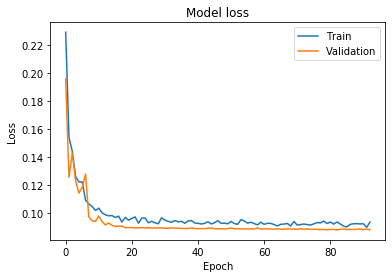

Training 3. Fold
X_train shape:  (4500000, 43)
y_train shape:  (4500000, 11)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 3, 43)        0                                            
__________________________________________________________________________________________________
conv1d_8 (Conv1D)               (None, 3, 128)       5632        input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1_8 (Batch (None, 3, 128)       512         conv1d_8[0][0]                   
__________________________________________________________________________________________________
activation_8 (Activation)       (None, 3, 128)       0           batch_normalization_v1_8[0][0]   
________________________________

Epoch 14/200
781/781 [==============================] - 237s 303ms/step - loss: 0.0984 - acc: 0.9611 - val_loss: 0.0906 - val_acc: 0.9646
Epoch 15/200
166666/166666 [==============================] - 90s 540us/sample - loss: 0.0923 - acc: 0.9640

Epoch 00015: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.
781/781 [==============================] - 237s 304ms/step - loss: 0.0990 - acc: 0.9617 - val_loss: 0.0923 - val_acc: 0.9640
Epoch 16/200
166666/166666 [==============================] - 91s 547us/sample - loss: 0.0907 - acc: 0.9647

Epoch 00016: ReduceLROnPlateau reducing learning rate to 1e-05.
781/781 [==============================] - 238s 305ms/step - loss: 0.0986 - acc: 0.9612 - val_loss: 0.0907 - val_acc: 0.9647
Epoch 17/200
781/781 [==============================] - 239s 307ms/step - loss: 0.0966 - acc: 0.9627 - val_loss: 0.0899 - val_acc: 0.9653
Epoch 18/200
781/781 [==============================] - 238s 305ms/step - loss: 0.0978 - acc: 0.9619 - val_loss

781/781 [==============================] - 409s 524ms/step - loss: 0.0954 - acc: 0.9631 - val_loss: 0.0890 - val_acc: 0.9655
Epoch 49/200
781/781 [==============================] - 407s 521ms/step - loss: 0.0964 - acc: 0.9625 - val_loss: 0.0892 - val_acc: 0.9653
Epoch 50/200
781/781 [==============================] - 394s 504ms/step - loss: 0.0956 - acc: 0.9635 - val_loss: 0.0889 - val_acc: 0.9656
Epoch 51/200
781/781 [==============================] - 415s 531ms/step - loss: 0.0939 - acc: 0.9631 - val_loss: 0.0892 - val_acc: 0.9652
Epoch 52/200
781/781 [==============================] - 409s 524ms/step - loss: 0.0932 - acc: 0.9637 - val_loss: 0.0889 - val_acc: 0.9654
Epoch 53/200
781/781 [==============================] - 410s 525ms/step - loss: 0.0931 - acc: 0.9641 - val_loss: 0.0890 - val_acc: 0.9654
Epoch 54/200
781/781 [==============================] - 416s 533ms/step - loss: 0.0931 - acc: 0.9640 - val_loss: 0.0893 - val_acc: 0.9652
Epoch 55/200
781/781 [=========================

781/781 [==============================] - 225s 289ms/step - loss: 0.0947 - acc: 0.9632 - val_loss: 0.0885 - val_acc: 0.9654
Epoch 84/200
781/781 [==============================] - 228s 291ms/step - loss: 0.0919 - acc: 0.9649 - val_loss: 0.0885 - val_acc: 0.9654
Epoch 85/200
781/781 [==============================] - 224s 287ms/step - loss: 0.0938 - acc: 0.9633 - val_loss: 0.0887 - val_acc: 0.9654
Epoch 86/200
781/781 [==============================] - 223s 285ms/step - loss: 0.0929 - acc: 0.9642 - val_loss: 0.0883 - val_acc: 0.9657
Epoch 87/200
781/781 [==============================] - 222s 285ms/step - loss: 0.0927 - acc: 0.9638 - val_loss: 0.0884 - val_acc: 0.9654
Epoch 88/200
781/781 [==============================] - 222s 284ms/step - loss: 0.0952 - acc: 0.9627 - val_loss: 0.0887 - val_acc: 0.9654
Epoch 00088: early stopping
val_macro_f1: 0.9326681116282359


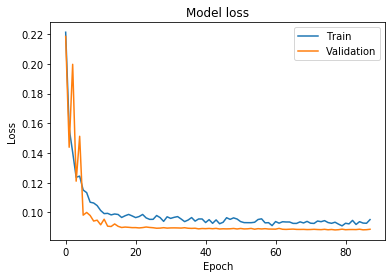

Training 4. Fold
X_train shape:  (4500000, 43)
y_train shape:  (4500000, 11)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 3, 43)        0                                            
__________________________________________________________________________________________________
conv1d_12 (Conv1D)              (None, 3, 128)       5632        input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1_12 (Batc (None, 3, 128)       512         conv1d_12[0][0]                  
__________________________________________________________________________________________________
activation_12 (Activation)      (None, 3, 128)       0           batch_normalization_v1_12[0][0]  
________________________________

Epoch 14/200
781/781 [==============================] - 223s 285ms/step - loss: 0.0988 - acc: 0.9618 - val_loss: 0.0905 - val_acc: 0.9656
Epoch 15/200
166666/166666 [==============================] - 84s 506us/sample - loss: 0.0903 - acc: 0.9654

Epoch 00015: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.
781/781 [==============================] - 222s 285ms/step - loss: 0.0983 - acc: 0.9619 - val_loss: 0.0904 - val_acc: 0.9654
Epoch 16/200
781/781 [==============================] - 222s 285ms/step - loss: 0.0968 - acc: 0.9625 - val_loss: 0.0900 - val_acc: 0.9656
Epoch 17/200
166666/166666 [==============================] - 84s 507us/sample - loss: 0.0903 - acc: 0.9655

Epoch 00017: ReduceLROnPlateau reducing learning rate to 1e-05.
781/781 [==============================] - 223s 285ms/step - loss: 0.0984 - acc: 0.9614 - val_loss: 0.0905 - val_acc: 0.9655
Epoch 18/200
781/781 [==============================] - 223s 285ms/step - loss: 0.0935 - acc: 0.9634 - val_loss

781/781 [==============================] - 223s 285ms/step - loss: 0.0931 - acc: 0.9643 - val_loss: 0.0888 - val_acc: 0.9661
Epoch 49/200
781/781 [==============================] - 222s 285ms/step - loss: 0.0933 - acc: 0.9639 - val_loss: 0.0888 - val_acc: 0.9662
Epoch 50/200
781/781 [==============================] - 223s 285ms/step - loss: 0.0955 - acc: 0.9621 - val_loss: 0.0899 - val_acc: 0.9653
Epoch 51/200
781/781 [==============================] - 223s 285ms/step - loss: 0.0942 - acc: 0.9631 - val_loss: 0.0891 - val_acc: 0.9659
Epoch 52/200
781/781 [==============================] - 222s 285ms/step - loss: 0.0940 - acc: 0.9636 - val_loss: 0.0890 - val_acc: 0.9659
Epoch 53/200
781/781 [==============================] - 223s 285ms/step - loss: 0.0908 - acc: 0.9645 - val_loss: 0.0887 - val_acc: 0.9661
Epoch 54/200
781/781 [==============================] - 223s 285ms/step - loss: 0.0942 - acc: 0.9641 - val_loss: 0.0891 - val_acc: 0.9659
Epoch 55/200
781/781 [=========================

781/781 [==============================] - 260s 333ms/step - loss: 0.0917 - acc: 0.9645 - val_loss: 0.0882 - val_acc: 0.9661
Epoch 84/200
781/781 [==============================] - 261s 334ms/step - loss: 0.0917 - acc: 0.9639 - val_loss: 0.0883 - val_acc: 0.9662
Epoch 85/200
781/781 [==============================] - 242s 309ms/step - loss: 0.0913 - acc: 0.9644 - val_loss: 0.0885 - val_acc: 0.9663
Epoch 86/200
781/781 [==============================] - 249s 319ms/step - loss: 0.0939 - acc: 0.9633 - val_loss: 0.0882 - val_acc: 0.9662
Epoch 87/200
781/781 [==============================] - 234s 300ms/step - loss: 0.0947 - acc: 0.9633 - val_loss: 0.0883 - val_acc: 0.9664
Epoch 88/200
781/781 [==============================] - 223s 285ms/step - loss: 0.0906 - acc: 0.9653 - val_loss: 0.0884 - val_acc: 0.9663
Epoch 89/200
781/781 [==============================] - 223s 285ms/step - loss: 0.0915 - acc: 0.9647 - val_loss: 0.0881 - val_acc: 0.9663
Epoch 90/200
781/781 [=========================

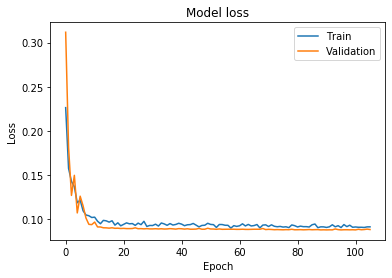

Training 5. Fold
X_train shape:  (4500000, 43)
y_train shape:  (4500000, 11)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 3, 43)        0                                            
__________________________________________________________________________________________________
conv1d_16 (Conv1D)              (None, 3, 128)       5632        input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1_16 (Batc (None, 3, 128)       512         conv1d_16[0][0]                  
__________________________________________________________________________________________________
activation_16 (Activation)      (None, 3, 128)       0           batch_normalization_v1_16[0][0]  
________________________________

Epoch 14/200
166666/166666 [==============================] - 85s 507us/sample - loss: 0.0906 - acc: 0.9645

Epoch 00014: ReduceLROnPlateau reducing learning rate to 1e-05.
781/781 [==============================] - 223s 286ms/step - loss: 0.0959 - acc: 0.9628 - val_loss: 0.0906 - val_acc: 0.9645
Epoch 15/200
781/781 [==============================] - 223s 286ms/step - loss: 0.0982 - acc: 0.9619 - val_loss: 0.0895 - val_acc: 0.9650
Epoch 16/200
781/781 [==============================] - 223s 285ms/step - loss: 0.0977 - acc: 0.9623 - val_loss: 0.0894 - val_acc: 0.9651
Epoch 17/200
781/781 [==============================] - 223s 286ms/step - loss: 0.0961 - acc: 0.9630 - val_loss: 0.0896 - val_acc: 0.9650
Epoch 18/200
781/781 [==============================] - 223s 286ms/step - loss: 0.0982 - acc: 0.9619 - val_loss: 0.0895 - val_acc: 0.9650
Epoch 19/200
781/781 [==============================] - 223s 286ms/step - loss: 0.1000 - acc: 0.9610 - val_loss: 0.0893 - val_acc: 0.9652
Epoch 20/200

Epoch 49/200
781/781 [==============================] - 223s 285ms/step - loss: 0.0984 - acc: 0.9624 - val_loss: 0.0887 - val_acc: 0.9653
Epoch 50/200
781/781 [==============================] - 223s 285ms/step - loss: 0.0951 - acc: 0.9629 - val_loss: 0.0885 - val_acc: 0.9652
Epoch 51/200
781/781 [==============================] - 223s 286ms/step - loss: 0.0963 - acc: 0.9631 - val_loss: 0.0888 - val_acc: 0.9652
Epoch 52/200
781/781 [==============================] - 223s 285ms/step - loss: 0.0969 - acc: 0.9622 - val_loss: 0.0883 - val_acc: 0.9654
Epoch 53/200
781/781 [==============================] - 223s 285ms/step - loss: 0.0965 - acc: 0.9625 - val_loss: 0.0884 - val_acc: 0.9654
Epoch 54/200
781/781 [==============================] - 223s 285ms/step - loss: 0.0968 - acc: 0.9626 - val_loss: 0.0885 - val_acc: 0.9654
Epoch 55/200
781/781 [==============================] - 223s 285ms/step - loss: 0.0968 - acc: 0.9620 - val_loss: 0.0882 - val_acc: 0.9654
Epoch 56/200
781/781 [============

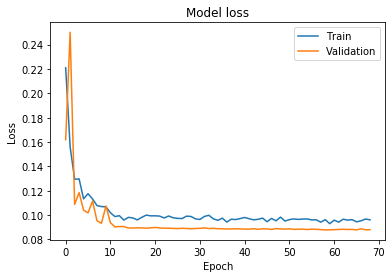

y_oof shape:  (833330, 11)
OOF Macro F1:  0.9338333428930596


In [11]:
# FOR CLASSIFICATION (N-length signal -> 1 label)
#TODO shuffle training set somehow
#TODO split training set to training and validation

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold, GroupKFold, StratifiedShuffleSplit
from sklearn.metrics import f1_score

# macro f1 score with one-hot encoded labels
def macro_f1(yoh_true, yoh_pred):
    y_true = np.argmax(yoh_true, axis=-1)
    y_pred = np.argmax(yoh_pred, axis=-1)
    return f1_score(y_true, y_pred, average='macro')

# numpy data for training
seg = 0
#features = ['signal', 'signal_sq', 'signal_sqroot', 
#            'rolling_mean_1001', 'rolling_std_1001', 'rolling_var_1001', 'rolling_min_1001', 'rolling_max_1001', 
#            'rolling_min_max_ratio_1001', 'rolling_max_min_diff_1001', 'norm_1001']
features = ['signal', 'signal_sq', 'signal_sqroot', 
            'rolling_mean_11', 'rolling_std_11', 'rolling_var_11', 'rolling_min_11', 'rolling_max_11', 
            'rolling_min_max_ratio_11', 'rolling_max_min_diff_11', 'norm_11', 
            
            'rolling_mean_25', 'rolling_std_25', 'rolling_var_25', 'rolling_min_25', 'rolling_max_25', 
            'rolling_min_max_ratio_25', 'rolling_max_min_diff_25', 'norm_25', 
            
            'rolling_mean_51', 'rolling_std_51', 'rolling_var_51', 'rolling_min_51', 'rolling_max_51', 
            'rolling_min_max_ratio_51', 'rolling_max_min_diff_51', 'norm_51', 
            
            'rolling_mean_101', 'rolling_std_101', 'rolling_var_101', 'rolling_min_101', 'rolling_max_101', 
            'rolling_min_max_ratio_101', 'rolling_max_min_diff_101', 'norm_101', 
            
            'rolling_mean_1001', 'rolling_std_1001', 'rolling_var_1001', 'rolling_min_1001', 'rolling_max_1001', 
            'rolling_min_max_ratio_1001', 'rolling_max_min_diff_1001', 'norm_1001']
n_before = 1
n_after = 1
SEQ_LEN = n_before + 1 + n_after

X = df_train[features].to_numpy()#[seg*500000:(seg+1)*500000]
y = df_train.open_channels.to_numpy()#[seg*500000:(seg+1)*500000]
y_oh = to_categorical(y, num_classes=11)

groups = df_train.batch.to_numpy()#[seg*500000:(seg+1)*500000]
print('full shape: X ', X.shape, ', y ', y.shape)
#print(y)

# cross validation training
oof_true = np.empty((0, 11))
oof_pred = np.empty((0, 11))
#kf = GroupKFold(n_splits=10)
#kf = KFold(n_splits=2)
#kf = StratifiedKFold(n_splits=5)
kf = StratifiedShuffleSplit(n_splits=5, random_state=0)
for kth, (train_index, val_index) in enumerate(kf.split(X, y, groups)):
    print(f'Training {kth+1}. Fold')
    #print("TRAIN:", train_index, "VAL:", val_index)
    X_train, X_test = X[train_index], X[val_index]
    #y_train, y_test = y[train_index], y[val_index]
    yoh_train, yoh_test = y_oh[train_index], y_oh[val_index]
    
    # scale data to (-1, 1) range and reshape
    x_scaler = MinMaxScaler(feature_range=(0, 1))
    X_train = x_scaler.fit_transform(X_train)
    X_test = x_scaler.transform(X_test)
    
    # reshape validation data
    n_val_samples = yoh_test.shape[0] // SEQ_LEN * SEQ_LEN
    X_test = X_test[:n_val_samples].reshape((-1, SEQ_LEN, len(features)))
    idx = np.array(range(0, n_val_samples, SEQ_LEN)) - n_after - 1
    idx = np.roll(idx, -1)
    idx[-1] = idx[-1] + n_val_samples
    yoh_test = yoh_test[idx]
    
    print('X_train shape: ', X_train.shape)
    print('y_train shape: ', yoh_train.shape)
    
    batch_size = 128
    gen = batch_generator(batch_size, X_train, yoh_train, n_before, n_after)
    
    # init model
    opt_adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    model = get_model((SEQ_LEN, len(features)), opt_adam)
    
    # define model callbacks
    callback_checkpoint = ModelCheckpoint(filepath=f'best_model_{kth}fold.h5', 
                               monitor='val_loss', 
                               verbose=1, 
                               save_weights_only=True, 
                               save_best_only=True)
    callback_early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
    callback_reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                                           factor=0.5, 
                                           patience=0, 
                                           verbose=1, 
                                           min_delta=1e-4, 
                                           min_lr=1e-5)
    callback_tensorboard = TensorBoard(log_dir=f'./logs_{kth}fold/', histogram_freq=0, write_graph=False)
    callback_macro_f1 = MacroF1(model, X_test, yoh_test)
    #cbs = [callback_checkpoint, callback_early_stopping, callback_reduce_lr, callback_tensorboard]
    cbs = [callback_early_stopping, callback_reduce_lr]    
    
    # train model
    history = model.fit(x=gen, 
                        epochs=200, 
                        steps_per_epoch=100_000//batch_size, 
                        verbose=1, 
                        validation_data=(X_test, yoh_test),
                        callbacks=cbs)
    
    # calculate macro f1 on val set
    yoh_pred = model.predict(X_test)
    score = macro_f1(yoh_test, yoh_pred)
    print(f'val_macro_f1: {score}')
    
    # append to oof arrays
    oof_true = np.append(oof_true, yoh_test, axis=0)
    oof_pred = np.append(oof_pred, yoh_pred, axis=0)
    
    # plot loss and val_loss wrt epoch
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper right')
    plt.show()
    
print('y_oof shape: ', oof_true.shape)
print('OOF Macro F1: ', macro_f1(oof_true, oof_pred))

In [12]:
yoh_pred = model.predict(X_test)
print(yoh_pred.shape)

#plt.figure(figsize=(25, 10))
#plt.plot(np.arange(SEQ_LEN), np.squeeze(X_test[220] * 10), color='blue', linewidth=10)
#plt.plot(np.arange(SEQ_LEN), y_test[220] * 10, color='orange', linewidth=5)
#plt.plot(np.arange(SEQ_LEN), np.rint(yoh_pred[220] * 10), color='black')

print(macro_f1(yoh_test, yoh_pred))

(166666, 11)
0.9332084474037411


In [21]:
del df_train

2000000

In [63]:
pd.concat([pd.DataFrame([df_new.iloc[0, :]]*n_before), df_new, pd.DataFrame([df_new.iloc[-1, :]]*n_after)], ignore_index=True).shape
#print(pd.DataFrame([df_new.iloc[0, :].values], columns=df_new.iloc[0, :].index.to_list()))
#print(pd.DataFrame([df_new.iloc[0, :]]))
#print(df_new.iloc[0, :].values)

(2000002, 45)

In [70]:
def save_submission(y_test):
    #submission = pd.read_csv("../input/liverpool-ion-switching/sample_submission.csv")
    submission = pd.read_csv("sample_submission.csv")
    submission["open_channels"] = np.asarray(y_test, dtype=np.int32)
    submission.to_csv("submission.csv", index=False, float_format="%.4f")

def prepare_new_data(df):
    # create X
    X = np.zeros((df.shape[0], SEQ_LEN, len(features)))
    # extend df with n_before and n_after rows
    df = pd.concat([pd.DataFrame([df.iloc[0, :]]*n_before), df, pd.DataFrame([df.iloc[-1, :]]*n_after)], 
                   ignore_index=True)
    for i in range(X.shape[0]):
        if i % 200_000 == 0: print(f'Processed {i} examples')
        X[i] = df.iloc[i:i+SEQ_LEN, :]

    return X
        
X_new = prepare_new_data(pd.DataFrame(x_scaler.transform(df_new[features].to_numpy())))
print(X_new.shape)
new_batch_size = 200_000
y_new = np.empty((0, 11))
for i in range(X_new.shape[0] // new_batch_size):
    y_new = np.append(y_new, model.predict(X_new[i*new_batch_size:(i+1)*new_batch_size]), axis=0)
    print(f'Processed {(i+1)*200_000} examples')
y_new = np.argmax(y_new, axis=-1)
save_submission(y_new)

Processed 0 examples
Processed 200000 examples
Processed 400000 examples
Processed 600000 examples
Processed 800000 examples
Processed 1000000 examples
Processed 1200000 examples
Processed 1400000 examples
Processed 1600000 examples
Processed 1800000 examples
(2000000, 3, 43)
Processed 0 examples
Processed 200000 examples
Processed 400000 examples
Processed 600000 examples
Processed 800000 examples
Processed 1000000 examples
Processed 1200000 examples
Processed 1400000 examples
Processed 1600000 examples
Processed 1800000 examples


In [6]:
# FOR SIGNAL-TO-SIGNAL TRANSLATION
#TODO split training set to training and validation

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold, GroupKFold, StratifiedShuffleSplit
from sklearn.metrics import f1_score

# macro f1 score
def macro_f1(y_true, y_pred):
    y_true = np.rint(y_true.reshape(-1))
    y_pred = np.rint(y_pred.reshape(-1))
    return f1_score(y_true, y_pred, average='macro')

# numpy data for training
seg = 9

X = df_train.signal.to_numpy()#[seg*500000:(seg+1)*500000]
X = X[:, np.newaxis]

y = df_train.open_channels.to_numpy()#[seg*500000:(seg+1)*500000]
y_oh = to_categorical(y, num_classes=11)

#print(X.shape, y.shape)
#print(y)

SEQ_LEN = 4096

# cross validation training
scores = []
#kf = GroupKFold(n_splits=10)
#kf = KFold(n_splits=2)
#kf = StratifiedKFold(n_splits=5)
kf = StratifiedShuffleSplit(n_splits=5, random_state=0)
for kth, (train_index, val_index) in enumerate(kf.split(X, y)):
    print(f'Training {kth+1}. Fold')
    #print("TRAIN:", train_index, "VAL:", val_index)
    X_train, X_test = X[train_index], X[val_index]
    y_train, y_test = y[train_index], y[val_index]
    #yoh_train, yoh_test = y_oh[train_index], y_oh[val_index]
    
    # scale data to (0, 1) range and reshape
    x_scaler = MinMaxScaler(feature_range=(0, 1))
    X_train = x_scaler.fit_transform(X_train)
    X_test = x_scaler.transform(X_test)
    
    y_train = y_train / 10
    y_test = y_test / 10
    
    # reshape validation data
    n_val_samples = y_test.shape[0] // SEQ_LEN * SEQ_LEN
    X_test = X_test[:n_val_samples].reshape((-1, SEQ_LEN, 1))
    y_test = y_test[:n_val_samples].reshape((-1, SEQ_LEN))
    
    # for classification
    #X_train = X_train.reshape((-1, SEQ_LEN, 1))
    #X_test = X_test.reshape((-1, SEQ_LEN, 1))
    print('X_train shape: ', X_train.shape)
    print('y_train shape: ', y_train.shape)
    
    batch_size = 128
    gen = seq2seq_generator(batch_size, X_train, y_train, SEQ_LEN)
    
    # init model
    opt_adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    model = get_model((SEQ_LEN, 1), opt_adam)
    
    # define model callbacks
    callback_checkpoint = ModelCheckpoint(filepath=f'best_model_{kth}fold.h5', 
                               monitor='val_loss', 
                               verbose=1, 
                               save_weights_only=True, 
                               save_best_only=True)
    callback_early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)
    callback_reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                                           factor=0.5, 
                                           patience=0, 
                                           verbose=1, 
                                           min_delta=1e-4, 
                                           min_lr=1e-5)
    callback_tensorboard = TensorBoard(log_dir=f'./logs_{kth}fold/', histogram_freq=0, write_graph=False)
    #callback_macro_f1 = MacroF1(model, X_test, yoh_test)
    #cbs = [callback_checkpoint, callback_early_stopping, callback_reduce_lr, callback_tensorboard]
    cbs = [callback_early_stopping, callback_reduce_lr]
    
    
    
    # train model
    history = model.fit(x=gen, 
                        epochs=200, 
                        steps_per_epoch=100_000//batch_size, 
                        verbose=1, 
                        validation_data=(X_test, y_test), 
                        callbacks=cbs)
    
    # calculate macro f1 on val set
    y_pred = model.predict(X_test)
    score = macro_f1(y_test * 10, y_pred * 10)
    print(f'val_macro_f1: {score}')
    scores.append(score)
    
    # plot loss and val_loss wrt epoch
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper right')
    plt.show()
    
print(scores)
print(np.mean(scores))

Training 1. Fold
X_train shape:  (4500000, 1)
y_train shape:  (4500000,)
Instructions for updating:
Use tf.cast instead.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 4096, 1)      0                                            
__________________________________________________________________________________________________
conv1d_8 (Conv1D)               (None, 2048, 64)     256         input_2[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_7 (LeakyReLU)       (None, 2048, 64)     0           conv1d_8[0][0]                   
__________________________________________________________________________________________________
conv1d_9 (Conv1D)               (None, 1024, 128)    24704       leaky_re_lu_7[0][0]   

Epoch 1/200
781/781 [==============================] - 250s 320ms/step - loss: 0.0092 - mean_absolute_error: 0.0647 - val_loss: 0.0058 - val_mean_absolute_error: 0.0525
Epoch 2/200
781/781 [==============================] - 253s 323ms/step - loss: 0.0055 - mean_absolute_error: 0.0504 - val_loss: 0.0054 - val_mean_absolute_error: 0.0490
Epoch 3/200
781/781 [==============================] - 262s 335ms/step - loss: 0.0053 - mean_absolute_error: 0.0478 - val_loss: 0.0053 - val_mean_absolute_error: 0.0472
Epoch 4/200
122/122 [==============================] - 0s 736us/sample - loss: 0.0052 - mean_absolute_error: 0.0459

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
781/781 [==============================] - 242s 310ms/step - loss: 0.0052 - mean_absolute_error: 0.0464 - val_loss: 0.0052 - val_mean_absolute_error: 0.0459
Epoch 5/200
781/781 [==============================] - 240s 307ms/step - loss: 0.0051 - mean_absolute_error: 0.0456 - val_loss: 0.0052 - va

KeyboardInterrupt: 

(122, 4096)
0.5808597210665313


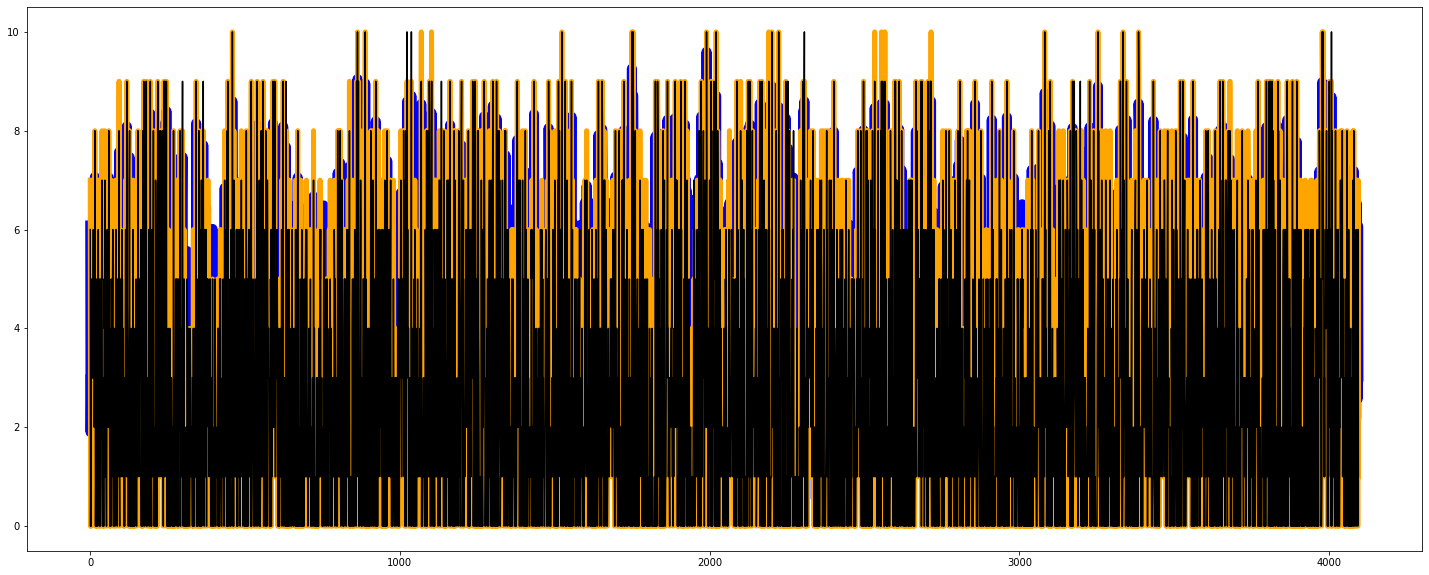

In [8]:
yoh_pred = model.predict(X_test)
print(yoh_pred.shape)

plt.figure(figsize=(25, 10))
plt.plot(np.arange(SEQ_LEN), np.squeeze(X_test[20] * 10), color='blue', linewidth=10)
plt.plot(np.arange(SEQ_LEN), y_test[20] * 10, color='orange', linewidth=5)
plt.plot(np.arange(SEQ_LEN), np.rint(yoh_pred[20] * 10), color='black')

print(f1_score(np.rint(y_test.reshape(-1) * 10), np.rint(yoh_pred.reshape(-1) * 10), average='macro'))